## Q1. データベース作成

ダウンロードしたcsvファイル内のデータをSQLiteのデータベースに格納せよ．テーブル名は`department`のように，csvファイル名から拡張子を取り除いたものにせよ．ただし，`order_products__train.csv`と`order_products__prior.csv`のデータについては，`order_products`というテーブルを作成し，そこにデータを格納せよ．カラム情報は`data/instacart`ディレクトリの`data-recipe.md`ファイルに記した内容に従うこと．

```
sqlite> .mode csv
sqlite> .import "./data/instacart_2017_05_01/aisles.csv" aisles
sqlite> .import "./data/instacart_2017_05_01/departments.csv" departments
sqlite> .import "./data/instacart_2017_05_01/order_products__prior.csv" order_products
sqlite> .import "./data/instacart_2017_05_01/order_products__train.csv" order_products
sqlite> .import "./data/instacart_2017_05_01/orders.csv" orders
sqlite> .import "./data/instacart_2017_05_01/products.csv" products
sqlite> .mode column
sqlite> delete from aisles where typeof(aisle_id) is not 'integer';
sqlite> delete from departments where typeof(department_id) is not 'integer';
sqlite> delete from order_products where typeof(order_id) is not 'integer';
sqlite> delete from orders where typeof(order_id) is not 'integer';
sqlite> delete from products where typeof(product_id) is not 'integer';
```

## Q2. pandasデータフレームへの読み込み
pandasライブラリの`read_sql`関数を用いると，SQLite上にあるデータベースにSQLを発行し，その結果を`pandas.DataFrame`データフレームに読み出すことができる．下記コードは，SQLite上にある`instacart`データベースの`department`テーブルの内容をデータフレームに読み込む例である．

`products`テーブル，`aisles`テーブル，`departments`テーブル，`orders`テーブル，`order_products`テーブルのレコード数を調べるSQL文を発行し，各テーブルのレコード数を表示せよ．

In [1]:
import sqlite3
import pandas
import pandas.io.sql as sql

In [5]:

connection = sqlite3.connect('../db/instacart.sqlite3')
count_query_products = 'select count(*) as "products record" from products;'
df_products = sql.read_sql(count_query_products, connection)

count_query_aisles = 'select count(*) as "aisles record" from aisles;'
df_aisles = sql.read_sql(count_query_aisles, connection)

count_query_departments = 'select count(*) as "departments record" from departments;'
df_departents = sql.read_sql(count_query_departments, connection)

count_query_orders = 'select count(*) as "orders record" from orders;'
df_orders = sql.read_sql(count_query_orders, connection)

count_query_order_products = 'select count(*) as "order_products record" from order_products;'
df_order_products = sql.read_sql(count_query_order_products, connection)

connection.close()

print(df_products)
print(df_aisles)
print(df_departents)
print(df_orders)
print(df_order_products)


products record
0            49688
   aisles record
0            134
   departments record
0                  21
   orders record
0        3421083
   order_products record
0               33819106


## Q3. マスターデータ作成（テーブル結合 & 集約演算）

商品部門別および商品棚別に商品数を求めるSQL文を発行し，その結果をデータフレーム形式で表示せよ．なお，表示するデータフレームは下記の形式とせよ．また表示する結果は，商品数の降順でソートしたものとせよ．

|| department | aisle | iterm_count |
|:-:|---|---|---|
|0|	personal care | ALL | 6563 |
||...|...|...|


In [3]:
connection = sqlite3.connect('../db/instacart.sqlite3')

query = '''
SELECT department, aisle, count(*) AS item_count
FROM aisles, departments, products
WHERE departments.department_id = products.department_id
AND aisles.aisle_id = products.aisle_id
GROUP BY department, aisle
UNION
SELECT department, "ALL" as aisle, count(*) AS item_count
FROM departments, products
WHERE departments.department_id = products.department_id
GROUP BY department

ORDER BY item_count DESC
'''

df_num = sql.read_sql(query, connection)
connection.close()

df_num


,department,aisle,item_count
0,personal care,ALL,6563
1,snacks,ALL,6264
2,pantry,ALL,5371
3,beverages,ALL,4365
4,frozen,ALL,4007
...,...,...,...
150,babies,baby accessories,44
151,bulk,ALL,38
152,produce,packaged produce,32
153,bulk,bulk grains rice dried goods,26


## Q4. 注文行動に関する基礎情報（集約演算2）
ユーザID毎に注文回数（`order_frequency`）および注文の平均間隔（`avg_order_interval`）を把握したい．注文回数が10回以上99以下のユーザに関して，ユーザID毎の注文回数と注文平均間隔を求めるSQL文を発行し，注文平均間隔の上位10件（昇順）のユーザ情報のみ表示せよ．結果はデータフレーム形式で表示せよ．

In [10]:
connection = sqlite3.connect('../db/instacart.sqlite3')

query = '''
SELECT user_id, count(*) as order_frequency, avg(days_since_prior) as avg_order_interval
FROM orders
GROUP BY user_id
HAVING order_frequency BETWEEN 10 AND 99
ORDER BY avg_order_interval ASC
LIMIT 10
'''

df_inter = sql.read_sql(query, connection)
connection.close()

df_inter


,user_id,order_frequency,avg_order_interval
0,88589,27,0.518519
1,58157,48,0.604167
2,31834,11,0.818182
3,204214,23,0.826087
4,190812,16,0.875000
5,309,26,0.961538
6,15963,10,1.000000
7,68345,10,1.000000
8,175931,42,1.000000
9,192717,10,1.000000


## Q5. 注文タイミング（ヒートマップによる可視化）
注文があった曜日および時間帯別（例: 土曜日の23時）の注文総数を集計するSQL文を発行し，その結果をヒートマップ形式で表示せよ．

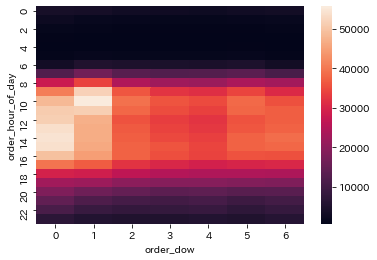

In [5]:
%matplotlib inline
import seaborn

connection = sqlite3.connect('../db/instacart.sqlite3')

query = '''
SELECT order_dow, order_hour_of_day, count(*) as order_count
FROM orders
GROUP BY order_dow, order_hour_of_day
'''

df_order_count = sql.read_sql(query, connection)
connection.close()

# クロス集計
df_pivot = pandas.pivot_table(data=df_order_count, values='order_count', columns='order_dow', index='order_hour_of_day', aggfunc='sum')

seaborn.heatmap(df_pivot)

In [6]:
df_pivot

order_dow,0,1,2,3,4,5,6
order_hour_of_day,,,,,,,
0,3936,3674,3059,2952,2642,3189,3306
1,2398,1830,1572,1495,1512,1672,1919
2,1409,1105,943,953,899,1016,1214
3,963,748,719,654,686,841,863
4,813,809,744,719,730,910,802
5,1168,1607,1399,1355,1330,1574,1136
6,3329,5370,4758,4562,4401,4866,3243
7,12410,16571,13245,12396,12493,13434,11319
8,28108,34116,24635,22553,21814,24015,22960


## Q6. 注文間隔（棒グラフによる可視化）
前回の注文からの経過日数別に注文数を集計するSQL文を発行し，その結果を棒グラフで示せ．

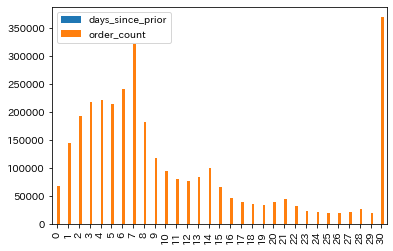

In [22]:
%matplotlib inline
import seaborn

connection = sqlite3.connect('../db/instacart.sqlite3')

query = '''
SELECT days_since_prior, count(*) as order_count
FROM orders
WHERE days_since_prior IS NOT ""
GROUP BY days_since_prior
ORDER BY days_since_prior ASC
'''

df_order_inter = sql.read_sql(query, connection)
connection.close()

df_order_inter.plot.bar()


## Q7. ユーザの利用頻度（副問い合わせ）
顧客の注文回数を集計することで注文回数別の顧客数を求めるSQL文を発行し，その結果を棒グラフで表示せよ．

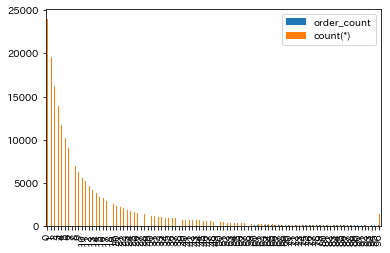

In [8]:
%matplotlib inline
import seaborn

connection = sqlite3.connect('../db/instacart.sqlite3')

query = '''
SELECT order_count, count(*)
FROM (
    SELECT user_id, count(*) as order_count
    FROM orders
    GROUP BY user_id
)
GROUP BY order_count
'''

df_user_count = sql.read_sql(query, connection)
connection.close()

df_user_count.plot.bar()


In [9]:
df_user_count

,order_count,count(*)
0,4,23986
1,5,19590
2,6,16165
3,7,13850
4,8,11700
...,...,...
92,96,67
93,97,54
94,98,50
95,99,47


## Q8. 再注文率（SQL上での算術演算）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果を表示せよ．なお，結果は再注文率でソートしたものを表示せよ．

In [12]:
connection = sqlite3.connect('../db/instacart.sqlite3')

query = '''
SELECT
    department,
    count(*) AS total_ordered,
    count(reordered=1 or NULL)*100.0 / count(*) AS 'reordered_prob'
FROM
    order_products ord
JOIN
    products pro USING(product_id)
JOIN
    departments dep USING(department_id)
GROUP BY
    department
ORDER BY
    reordered_prob DESC
;
'''

better_query = '''
SELECT
    department,
    count(*) AS total_ordered,
    sum(reordered)*100.0 / count(*) AS 'reordered_prob'
FROM
    order_products ord
JOIN
    products pro USING(product_id)
JOIN
    departments dep USING(department_id)
GROUP BY
    department
ORDER BY
    reordered_prob DESC
;
'''
# 取得する際はいじらず（桁数とか），表示の段階でいじったほうがいい．

df_reorder_prob = sql.read_sql(better_query, connection)
connection.close()

df_reorder_prob

,department,total_ordered,reordered_prob
0,dairy eggs,5631067,67.016127
1,beverages,2804175,65.365107
2,produce,9888378,65.052084
3,bakery,1225181,62.838062
4,deli,1095540,60.813024
5,pets,102221,60.255720
6,babies,438743,57.767987
7,bulk,35932,57.709006
8,snacks,3006412,57.446385
9,alcohol,159294,57.122051


## Q9. 商品棚にみる注文回数の分布（Window関数で四分位数を求める）
"pantry"売り場の商品棚別に注文回数の四分位数を求めるSQL文を発行し，その結果をデータフレームに格納し表示せよ．


In [ ]:
#ntail

## Q10. 商品棚別の注文数および再注文率（リッチな可視化）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果をデータフレームに格納せよ．また，集計結果をもとに，X軸に注文総数（対数スケール），Y軸に再注文率とする散布図を描け．